## Loading the packages

In [1]:
import os
import numpy as np

import utils.ImagesProcessor as ip
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import itertools
import time
import models.CAE as cae

slicesSize = np.array([28, 28, 3])
overlap = 5
ratioTrainTest = 0.8
inputShape = np.array([300, 300, 3])
K = 4

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading the datasets

In [2]:
def loadImages(directory_name):
    directory = os.fsencode(directory_name)
    imgs = []
    filenames = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.lower().endswith(".jpg"): 
            img = IP.readImage(directory_name + "/" + filename)
            img = IP.resizeImage(img, inputShape[:-1])
            img = IP.extractChromaticity(img)
            img_slices = IP.sliceImage(img,(slicesSize[0], slicesSize[1]),overlap)
            imgs.append(img_slices)
            filenames.append(filename)
    return np.array(imgs), filenames

In [3]:
TRAINING_PATH = "datasets/jardin_landscape/validation/dataset_train"
NORMAL_PATH = "datasets/jardin_landscape/validation/dataset_normal"
ANOMALY_PATH = "datasets/jardin_landscape/validation/dataset_anomaly"
IP = ip.ImagesProcessor()

# Load the images
X_train, trainFilenames = loadImages(TRAINING_PATH)
X_normal, normalFilenames= loadImages(NORMAL_PATH)
X_anomaly, anomalyFilenames = loadImages(ANOMALY_PATH)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


In [12]:
# Normalize them
X_train = X_train.astype('float32')/255.0
X_normal = X_normal.astype('float32')/255.0
X_anomaly = X_anomaly.astype('float32')/255.0

print(X_train.shape)
#print(X_train)
print(X_normal.shape)
#print(X_normal)
print(X_anomaly.shape)
#print(X_anomaly)
#print(X)

(7, 196, 28, 28, 3)
(12, 196, 28, 28, 3)
(18, 196, 28, 28, 3)


## Define the KNN needed functions

In [5]:
def euclidienne_distance(data1, data2):    
    return np.sum(np.power(np.array(data1) - np.array(data2), 2))

def manhattan_distance(data1, data2): 
    return np.sum(np.absolute(np.array(data1) - np.array(data2)))


def get_neighbors(training_set, 
          data_point, 
          k, 
          distance=euclidienne_distance):
    distances = []
    for indexTrain in range(len(training_set)):
        dist = distance(data_point, training_set[indexTrain])
        distances.append(dist)
    distances.sort()
    neighbors = distances[:k]
    mean_distance = np.max(neighbors)
    return mean_distance

## Explore  parameters

In [6]:
def testKNN(datasetSize):
    time1 = time.time()
    x_temp = X_train.reshape(-1, slicesSize[0], slicesSize[1], slicesSize[2])
    x_temp = x_temp[0:datasetSize]
    x_temp = np.random.permutation(x_temp)
    x_train = x_temp[:int(ratioTrainTest*len(x_temp))]
    x_test = x_temp[int(ratioTrainTest*len(x_temp)):]
    autoencoder = cae.CAE(slicesSize,nbNeuronsLayers=[16, 8, 8], nbConvFilters=(3,3), poolScale=(2, 2))
    autoencoder.createModel()
    autoencoder.train(x_train, x_test, epochs=300, batch_size=64)
    
    X_train_features = []
    for img in X_train:
        X_train_features.append(autoencoder.extractFeatures(img))
    X_train_features = np.array(X_train_features)
    print(X_train_features.shape)

    X_normal_features = []
    for img in X_normal:
        X_normal_features.append(autoencoder.extractFeatures(img))
    X_normal_features = np.array(X_normal_features)
    print(X_normal_features.shape)

    X_anomaly_features = []
    for img in X_anomaly:
        X_anomaly_features.append(autoencoder.extractFeatures(img))
    X_anomaly_features = np.array(X_anomaly_features)
    print(X_anomaly_features.shape)

    train_distances = []
    for img_index in range(X_train_features.shape[0]):
        slices_distances = []
        for slice_img in X_train_features[img_index]:
            slices_distances.append(get_neighbors(X_train_features.reshape(-1, X_train_features.shape[2], X_train_features.shape[3], X_train_features.shape[4]), slice_img, K+1))
        train_distances.append(np.max(slices_distances))
        print(trainFilenames[img_index], " - mean : ", np.max(slices_distances))

    deltaError = np.max(train_distances)#np.percentile(train_distances, 75)
    print("deltaError=", deltaError)

    test_distances = []
    for img_index in range(X_normal_features.shape[0]):
        classe = 1
        for slice_img in X_normal_features[img_index]:
            slices_distance = get_neighbors(X_train_features.reshape(-1, X_train_features.shape[2], X_train_features.shape[3], X_train_features.shape[4]), slice_img, K)
        #mean = np.mean(slices_distances)
            if slices_distance > deltaError:
                classe = -1
                break


        print(normalFilenames[img_index], " - classe : ", classe)
        test_distances.append(classe)

    for img_index in range(X_anomaly_features.shape[0]):
        slices_distances = []
        for slice_img in X_anomaly_features[img_index]:
            slices_distance = get_neighbors(X_train_features.reshape(-1, X_train_features.shape[2], X_train_features.shape[3], X_train_features.shape[4]), slice_img, K)
        #mean = np.mean(slices_distances)
            #print(slices_distance)
            if slices_distance > deltaError:
                classe = -1
                break
        test_distances.append(classe)
        print(anomalyFilenames[img_index], " - classe : ", classe)
    time2 = time.time()
    return accuracy_score(test_distances, [1]*len(X_normal_features) + [-1]*len(X_anomaly_features)), (time2-time1)*1000
#print(testCAE())

In [7]:
'''
datasetSize = np.arange(2,8,1)
fig, axe1 = plt.subplots()
axes = [testKNN(x) for x in datasetSize]
accurencies = [i[0] for i in axes]
times = [i[1] for i in axes]
print(accurencies)
graph = axe1.plot(datasetSize, accurencies, 'r')
axe1.set_xlabel('number of train samples')
axe1.set_ylabel('Accuracy', color='r')

axe2 = axe1.twinx()
axe2.plot(datasetSize, times, 'b')
axe2.set_ylabel('Time(s)', color='b')
plt.show()
'''

"\ndatasetSize = np.arange(2,8,1)\nfig, axe1 = plt.subplots()\naxes = [testKNN(x) for x in datasetSize]\naccurencies = [i[0] for i in axes]\ntimes = [i[1] for i in axes]\nprint(accurencies)\ngraph = axe1.plot(datasetSize, accurencies, 'r')\naxe1.set_xlabel('number of train samples')\naxe1.set_ylabel('Accuracy', color='r')\n\naxe2 = axe1.twinx()\naxe2.plot(datasetSize, times, 'b')\naxe2.set_ylabel('Time(s)', color='b')\nplt.show()\n"

## Final Model

In [8]:
x_temp = X_train.reshape(-1, slicesSize[0], slicesSize[1], slicesSize[2])
x_temp = np.random.permutation(x_temp)
x_train = x_temp[:int(ratioTrainTest*len(x_temp))]
x_test = x_temp[int(ratioTrainTest*len(x_temp)):]
autoencoder = cae.CAE(slicesSize,nbNeuronsLayers=[16, 8, 8], nbConvFilters=(3,3), poolScale=(2, 2))
autoencoder.createModel()
autoencoder.train(x_train, x_test, epochs=100, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

Epoch 42/100
1097/1097 [==============================] - 1s 1ms/step - loss: 8.1891e-04 - val_loss: 8.8076e-04
Epoch 43/100
1097/1097 [==============================] - 1s 1ms/step - loss: 8.1661e-04 - val_loss: 8.7702e-04
Epoch 44/100
1097/1097 [==============================] - 1s 1ms/step - loss: 8.1047e-04 - val_loss: 8.7456e-04
Epoch 45/100
1097/1097 [==============================] - 1s 1ms/step - loss: 8.0645e-04 - val_loss: 8.7675e-04
Epoch 46/100
1097/1097 [==============================] - 1s 993us/step - loss: 8.0615e-04 - val_loss: 8.6793e-04
Epoch 47/100
1097/1097 [==============================] - 1s 1ms/step - loss: 8.1005e-04 - val_loss: 8.7914e-04
Epoch 48/100
1097/1097 [==============================] - 1s 1ms/step - loss: 8.0157e-04 - val_loss: 8.6061e-04
Epoch 49/100
1097/1097 [==============================] - 1s 1ms/step - loss: 7.9336e-04 - val_loss: 8.6040e-04
Epoch 50/100
1097/1097 [==============================] - 1s 1ms/step - loss: 7.9083e-04 - val_loss: 8

In [9]:
X_train_features = []
for img in X_train:
    X_train_features.append(autoencoder.extractFeatures(img))
X_train_features = np.array(X_train_features)
print(X_train_features.shape)

X_normal_features = []
for img in X_normal:
    X_normal_features.append(autoencoder.extractFeatures(img))
X_normal_features = np.array(X_normal_features)
print(X_normal_features.shape)

X_anomaly_features = []
for img in X_anomaly:
    X_anomaly_features.append(autoencoder.extractFeatures(img))
X_anomaly_features = np.array(X_anomaly_features)
print(X_anomaly_features.shape)

train_distances = []
for img_index in range(X_train_features.shape[0]):
    slices_distances = []
    for slice_img in X_train_features[img_index]:
        slices_distances.append(get_neighbors(X_train_features.reshape(-1, X_train_features.shape[2], X_train_features.shape[3], X_train_features.shape[4]), slice_img, K+1))
    train_distances.append(np.max(slices_distances))
    print(trainFilenames[img_index], " - mean : ", np.max(slices_distances))

deltaError = np.max(train_distances)#np.percentile(train_distances, 75)
print("deltaError=", deltaError)

test_distances = []
for img_index in range(X_normal_features.shape[0]):
    classe = 1
    for slice_img in X_normal_features[img_index]:
        slices_distance = get_neighbors(X_train_features.reshape(-1, X_train_features.shape[2], X_train_features.shape[3], X_train_features.shape[4]), slice_img, K)

        if slices_distance > deltaError:
            classe = -1
            break
           
            
    print(normalFilenames[img_index], " - classe : ", classe)
    test_distances.append(classe)
    
for img_index in range(X_anomaly_features.shape[0]):
    slices_distances = []
    for slice_img in X_anomaly_features[img_index]:
        slices_distance = get_neighbors(X_train_features.reshape(-1, X_train_features.shape[2], X_train_features.shape[3], X_train_features.shape[4]), slice_img, K)
        
        if slices_distance > deltaError:
            classe = -1
            break
    test_distances.append(classe)
    print(anomalyFilenames[img_index], " - classe : ", classe)
    
    

(7, 196, 4, 4, 8)
(12, 196, 4, 4, 8)
(18, 196, 4, 4, 8)
NA_IMG_0260.jpg  - mean :  0.045600574
NA_IMG_0273.jpg  - mean :  0.03573832
NA_IMG_0388.jpg  - mean :  0.019053597
NA_IMG_0377.jpg  - mean :  0.018485408
NA_0268.jpg  - mean :  0.04617075
NA_IMG_0426.jpg  - mean :  0.026509022
NA_0267.jpg  - mean :  0.021681115
deltaError= 0.04617075
NA_IMG_0360.jpg  - classe :  1
NA_IMG_0362.jpg  - classe :  1
NA_IMG_0376.jpg  - classe :  1
NA_0244.jpg  - classe :  1
NA_IMG_0411.jpg  - classe :  -1
NA_0240.jpg  - classe :  1
NA_IMG_0366.jpg  - classe :  1
NA_IMG_0428.jpg  - classe :  1
NA_IMG_0370.jpg  - classe :  1
NA_IMG_0364.jpg  - classe :  1
NA_IMG_0385.jpg  - classe :  1
NA_IMG_0278.jpg  - classe :  1
A_IMG_0321.jpg  - classe :  1
A_IMG_0322.jpg  - classe :  1
HA_IMG_0425.jpg  - classe :  -1
HA_IMG_0424.jpg  - classe :  -1
HA_IMG_0418.jpg  - classe :  -1
A_IMG_0423.jpg  - classe :  -1
A_IMG_0345.jpg  - classe :  -1
A_IMG_0390.jpg  - classe :  -1
A_IMG_0409.jpg  - classe :  -1
A_IMG_0353.jp

[1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


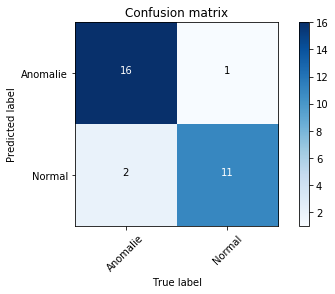

In [10]:
print(test_distances)
print([1]*len(X_normal_features) + [-1]*len(X_anomaly_features))
conf_mat = confusion_matrix(test_distances, [1]*len(X_normal_features) + [-1]*len(X_anomaly_features))

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):     
    labels_names_ref = ["Anomalie", "Normal"]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels_names_ref))
    plt.xticks(tick_marks, labels_names_ref, rotation=45)
    plt.yticks(tick_marks, labels_names_ref)
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
plot_confusion_matrix(conf_mat)

In [11]:
print("Accuracy:", accuracy_score(test_distances, [1]*len(X_normal_features) + [-1]*len(X_anomaly_features)))
precision = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[1][0]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[0][1]))/2
print("Precision: ", precision)
recall = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[1][0]))/2
print("Recall: ", recall)
f1score = 2*(precision*recall)/(precision+recall)
print("F1-Score: ", f1score)

Accuracy: 0.9
Precision:  0.9027777777777777
Recall:  0.8936651583710407
F1-Score:  0.8981983557810039
